In [1]:
import torch
import math
from glob import glob
import random


In [2]:

files = glob( '/home/loganaw/sonic_link/590/sliced_out/MET_SUB/*' )
random.shuffle( files )

train_files = files[:8000]
test_files = files[8000:9000]
validate_files = files[9000:]


In [3]:
files = glob( '/home/loganaw/sonic_link/590/sliced_out/MET/*' )
random.shuffle( files )
train_files = files[:20000]
print( len( train_files ) ) 

20000


In [4]:
train_files = open( 'weighted_sample.txt', 'r').read().splitlines()[:-1]
random.shuffle( train_files )
print( len( train_files ) )

23618


In [5]:
from PIL import Image
import PIL.ImageOps
import numpy as np

train_data = []
train_ans_data = []

TILE_SIZE = 64

for i,fname in enumerate( train_files ):
    f = Image.open(fname)
    fi = PIL.ImageOps.invert(f)
    fa = np.array( fi, dtype=np.float )
    
    train_ans_data.append( np.mean( fa[:TILE_SIZE,:TILE_SIZE,:2] ) )
    
    fa = fa[:TILE_SIZE, 256:256+TILE_SIZE, :]
    
    for i in range( 3 ):
        rge = [ np.min( fa[:,:,i] ), np.max( fa[:,:,i] ) ]
        fa[:,:,i] -= rge[0]
        fa[:,:,i] /= rge[1]
        fa[:,:,i] -= 0.5
    
    fa = np.moveaxis( fa, 2, 0 )
    fa = np.expand_dims(fa, 0)
    
    train_data.append( torch.tensor( fa ) ) 
    
    f.close()
    fi.close()


In [6]:
batch_data = []
batch_ans_data = []

MINI_BATCH = 100 
for i in range( 0, 23600, MINI_BATCH ):
    batch_data.append( torch.cat( train_data[i:][:MINI_BATCH] ) )
    batch_ans_data.append( torch.tensor( train_ans_data[i:][:MINI_BATCH] ) )

In [7]:
batch_data[0].size()

torch.Size([100, 3, 64, 64])

In [9]:
train_ans_data[0].dtype

dtype('float64')

In [10]:
from torch import nn

In [11]:
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, LeakyReLU

In [37]:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 4, kernel_size=4, stride=1, padding=2),
            BatchNorm2d(4),
            LeakyReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            LeakyReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            LeakyReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(256, 100),
            Linear(100, 1)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [38]:
net = Net()

net

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01, inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=256, 

In [39]:
import torch.optim
#from torch.nn import L1Loss

#criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=10e-6, momentum=0.95)
#criterion = L1Loss()

loss_plot = [ [], [] ]

for epoch in range(200):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, (inputs,labels) in enumerate( zip( batch_data, batch_ans_data ) ):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net( inputs.float() )
        #loss = ( outputs - labels )**2.0
        loss = torch.mean( ( outputs[:,0] - labels )**2.0 )
        #loss = criterion( outputs[:,0], labels )
        
        loss.backward()
        optimizer.step()

        # print statistics
        #running_loss += loss.item()
        
        loss_plot[0].append( i + epoch * len(batch_data) )
        loss_plot[1].append( loss.item() )
        
        #print( outputs, labels )
        if i % 20 == 0 : #i % 1000 == 1000 - 1:    # print every 2000 mini-batches
            print( '[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss.item() ) )
            print( 'Test =', net( train_data[0].float() ).item(), net( train_data[1].float() ).item() )
            running_loss = 0.0


print('Finished Training')

[1,     1] loss: 1268.850
Test = -0.425710529088974 -0.3630094528198242
[1,    21] loss: 846.819
Test = 10.685508728027344 10.009482383728027
[1,    41] loss: 321.612
Test = 35.41018295288086 36.701072692871094
[1,    61] loss: 341.525
Test = 26.764530181884766 28.25602912902832
[1,    81] loss: 280.807
Test = 31.733196258544922 34.00397872924805
[1,   101] loss: 200.474
Test = 29.718833923339844 32.3026123046875
[1,   121] loss: 251.225
Test = 30.443950653076172 33.078365325927734
[1,   141] loss: 274.171
Test = 31.63004493713379 34.026939392089844
[1,   161] loss: 287.607
Test = 29.830480575561523 31.935455322265625
[1,   181] loss: 288.178
Test = 30.895784378051758 33.10701370239258
[1,   201] loss: 292.802
Test = 29.464391708374023 31.98002052307129
[1,   221] loss: 387.971
Test = 31.940736770629883 34.76436996459961
[2,     1] loss: 279.435
Test = 29.86141586303711 32.68475341796875
[2,    21] loss: 355.824
Test = 31.528175354003906 34.135406494140625
[2,    41] loss: 230.996
Test

KeyboardInterrupt: 

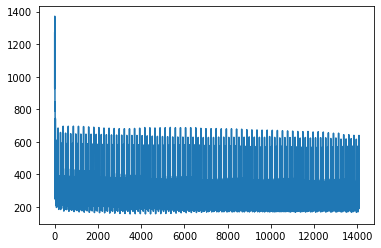

In [40]:
import seaborn as sns

sns.lineplot( loss_plot[0], loss_plot[1] )

In [29]:
outputs[:,0]

tensor([18.1267, 21.0215, 23.4486, 29.0702, 25.0288, 33.0197, 29.1144, 30.7057,
        32.5212, 29.0400, 24.6836, 17.8344, 34.6314, 40.5332, 17.9979, 35.8910,
        37.0301, 25.7292, 33.1206, 36.8760, 25.6732, 32.1442, 19.4441, 29.3572,
        26.4550, 47.0285, 25.2724, 25.5403, 36.4661, 31.4612, 28.5465, 29.4981,
        30.6531, 23.1798, 32.5789, 30.6820, 39.0094, 11.9133, 27.5899, 35.9370,
        35.1398, 16.7658, 31.0877, 21.7008, 42.0343, 19.4606, 29.6308, 26.1077,
        21.4473, 34.3523, 27.8042, 22.9143, 35.2841, 22.2327, 35.8741, 38.1098,
        19.5683, 23.5931, 27.9297, 35.5297, 26.5219, 32.9863, 30.2562, 40.1617,
        33.1889, 22.8866, 24.8758, 35.8870, 23.7229, 28.4670, 33.7398, 21.7962,
        24.3685, 39.6090, 30.6358, 29.3107, 10.9133, 25.0062, 32.9603, 27.5917,
        24.3459, 35.6334, 31.5141, 38.5714, 33.6356, 24.3191, 40.4372, 30.1605,
        17.9530, 32.0870, 31.6394, 21.4060, 27.9687, 29.0737, 37.2516, 37.2285,
        32.6167, 15.4580, 31.5784, 22.47

In [30]:
labels

tensor([14.0182, 15.5767, 41.7014, 53.0310, 25.5131, 51.0569, 48.7170, 79.2410,
        22.5334, 41.3524, 17.6372, 12.5715, 73.8777, 35.9623, 38.9937, 38.0874,
        68.6073, 18.2507, 18.2703, 25.6499, 52.4302, 22.2456, 14.3237, 42.8813,
        15.5952, 23.8115, 49.0974, 49.0466, 18.1766, 12.9878, 38.9713, 40.8019,
        39.2880, 13.6157, 41.3237, 17.3279, 43.7137, 12.7371, 24.1051, 64.7263,
        26.3618, 13.1803, 35.0052, 12.0717, 82.9658, 14.8160, 16.7922, 19.2915,
        22.3839, 78.1140, 21.1267, 55.8741, 49.8474, 52.3157, 20.8414, 40.6985,
        18.1781, 22.3818, 20.1986, 57.3737, 47.3464, 46.1805, 18.3068, 14.2412,
        25.1653, 64.3138, 24.0580, 69.3617, 42.2439, 19.0336, 61.2217, 14.8301,
        13.3885, 63.3660, 17.5238, 12.3361, 22.6265, 29.4226, 70.3064, 15.9906,
        19.0691, 69.2628, 15.9868, 25.0061, 70.2240, 53.2316, 51.2600, 11.0099,
         6.7311, 20.4058, 10.1279, 16.0742, 45.8842, 23.9897, 40.0656, 17.9863,
        12.4193, 13.3854, 13.2865, 12.93

In [31]:
torch.mean( torch.abs( outputs[:,0] - labels )**2.0 )

tensor(347.4461, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [32]:
train_ans_data[:2]

[26.447021484375, 11.91796875]

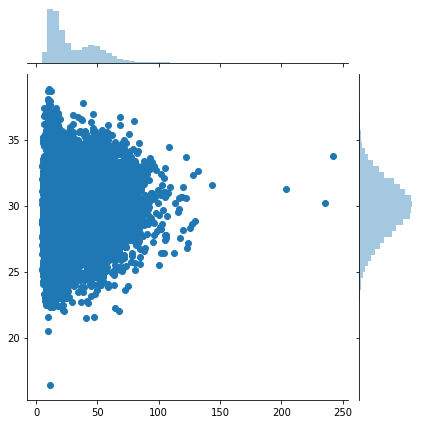

In [33]:
import seaborn as sns

trues = [ x.item() for x in train_ans_data ]
preds = [ net(x.float()).item() for x in train_data ]

sns.jointplot( trues, preds )

In [35]:
import scipy.stats

res = scipy.stats.linregress(trues, preds)
print( "P Value = ", res.pvalue )
res

P Value =  9.078155101078826e-146


LinregressResult(slope=0.019545062116703687, intercept=29.2059652089479, rvalue=0.16613783728243445, pvalue=9.078155101078826e-146, stderr=0.0007548964961972685)

In [41]:
import scipy.stats

res = scipy.stats.linregress(loss_plot[0], loss_plot[1])
print( "P Value = ", res.pvalue )
res

P Value =  2.3092779454937647e-56


LinregressResult(slope=-0.0023411751649873953, intercept=289.75174934781086, rvalue=-0.1327155918375282, pvalue=2.3092779454937647e-56, stderr=0.00014734011317510797)